In [52]:
import datetime
import logging
import pickle
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
from prophet import Prophet
from prophet.plot import plot_yearly, plot_seasonality
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

sys.path.append("..")
from src.processing import preprocessing

# https://stackoverflow.com/questions/66667909/stop-printing-infocmdstanpystart-chain-1-infocmdstanpyfinish-chain-1
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DatetimeProperties.to_pydatetime is deprecated")

DATA_DIR = Path("../data")

In [6]:
df = pl.read_csv(DATA_DIR / "PJME_hourly.csv")
split_date = datetime.datetime(2015, 1, 1)

df = preprocessing(df)
df_train, df_test = df.filter(pl.col("ds") <= split_date), df.filter(pl.col("ds") > split_date)
df, df_train, df_test = df.to_pandas(), df_train.to_pandas(), df_test.to_pandas()

## 3rdモデル
- 電力需要は特に月変動が激しいので、`yearly_seasonality`を調整してみる
  - `weekly_seasonality`や`yearly_seasonality`はデフォルトで考慮される一方で、`monthly_seasonality`はデフォルトでは考慮されない。
    - `add_seasonality`で追加することができる
  - それぞれ指定する値は、周期性をいくつのフーリエ波を合成した波として表現するかを決めるもの
    - 数値が大きいほど複雑な表現ができるが、overfittingのリスクが高まる
- 月変動と同様に、曜日による変動も大きいので、`weekly_seasonality`も調整してみる
- pjme電力需要の主要地域における平均気温情報をイベント情報として加える -> 4thモデルで

### yearly_seasonalityの調整
`yearly_seasonality=2`が最もMAEが低い結果。年間季節変動は2つの波の合成波として表現されたシンプルなものが良い結果になった。

In [18]:
outputs = []
best_yearly_seasonality, best_score = None, np.inf
for i in tqdm(range(2, 22, 2), total=len(range(2, 22, 2))):
    model = Prophet(yearly_seasonality=i)  # デフォルトでは10
    model.fit(df_train)

    preds = model.predict(df_test)
    mae = mean_absolute_error(
        df_test["y"],
        pl.DataFrame(preds).filter(pl.col("ds") > split_date)["yhat"],
    )
    if mae < best_score:
        best_score = mae
        best_yearly_seasonality = i
    
    outputs.append(f"yearly_seasonality={i} MAE: {mae}")  # baseline MAE: 5182.584236652587

for output in outputs:
    print(output)
print(f"best_yearly_seasonality: {best_yearly_seasonality}, best_score: {best_score}")

100%|██████████| 10/10 [07:02<00:00, 42.21s/it]

yearly_seasonality=2 MAE: 5159.096527450906
yearly_seasonality=4 MAE: 5173.949095585658
yearly_seasonality=6 MAE: 5174.725469103676
yearly_seasonality=8 MAE: 5177.057692831281
yearly_seasonality=10 MAE: 5182.584236652587
yearly_seasonality=12 MAE: 5183.66550570129
yearly_seasonality=14 MAE: 5188.495371971558
yearly_seasonality=16 MAE: 5192.234491657107
yearly_seasonality=18 MAE: 5184.7922568875065
yearly_seasonality=20 MAE: 5191.718613694592
best_yearly_seasonality: 2, best_score: 5159.096527450906


年間季節性の波は綺麗でシンプルな形になっている。夏場と冬場に電力消費量が多い傾向を示している。

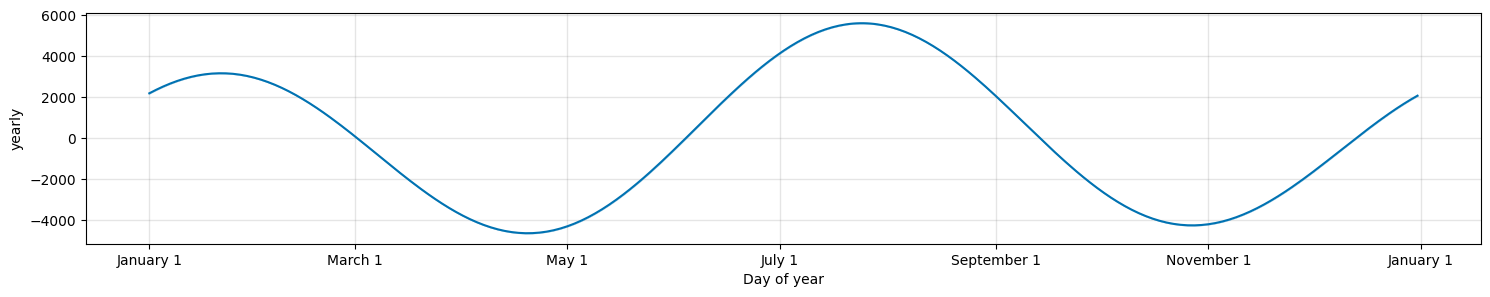

In [38]:
model = Prophet(yearly_seasonality=2)  # best_yearly_seasonality=2
model.fit(df_train)

plot_yearly(model, figsize=(18, 3));

### weekly_seasonalityの調整
`weekly_seasonality=1`が最も良い結果になった。シンプルなモデルで十分モデリングできるデータなのかもしれない。

In [20]:
outputs = []
best_weekly_seasonality, best_score = None, np.inf
for i in tqdm(range(1, 11), total=len(range(1, 11))):
    model = Prophet(yearly_seasonality=2, weekly_seasonality=i)  # weekly_seasonalityのデフォルトは3
    model.fit(df_train)

    preds = model.predict(df_test)
    mae = mean_absolute_error(
        df_test["y"],
        pl.DataFrame(preds).filter(pl.col("ds") > split_date)["yhat"],
    )
    if mae < best_score:
        best_score = mae
        best_weekly_seasonality = i
    
    outputs.append(f"weekly_seasonality={i} MAE: {mae}")  # baseline MAE: 5182.584236652587

for output in outputs:
    print(output)
print(f"best_weekly_seasonality: {best_weekly_seasonality}, best_score: {best_score}")

100%|██████████| 10/10 [06:08<00:00, 36.84s/it]

weekly_seasonality=1 MAE: 5100.535160661208
weekly_seasonality=2 MAE: 5156.131360053782
weekly_seasonality=3 MAE: 5159.096527450906
weekly_seasonality=4 MAE: 5164.937132067363
weekly_seasonality=5 MAE: 5177.678695838286
weekly_seasonality=6 MAE: 5184.772948737761
weekly_seasonality=7 MAE: 5182.017618087071
weekly_seasonality=8 MAE: 5186.392107532063
weekly_seasonality=9 MAE: 5187.613511460085
weekly_seasonality=10 MAE: 5190.120010878392
best_weekly_seasonality: 1, best_score: 5100.535160661208


完全な1種類の波で表現される。平日に電力消費量が高く、休日に低い傾向を最もシンプルに表現している

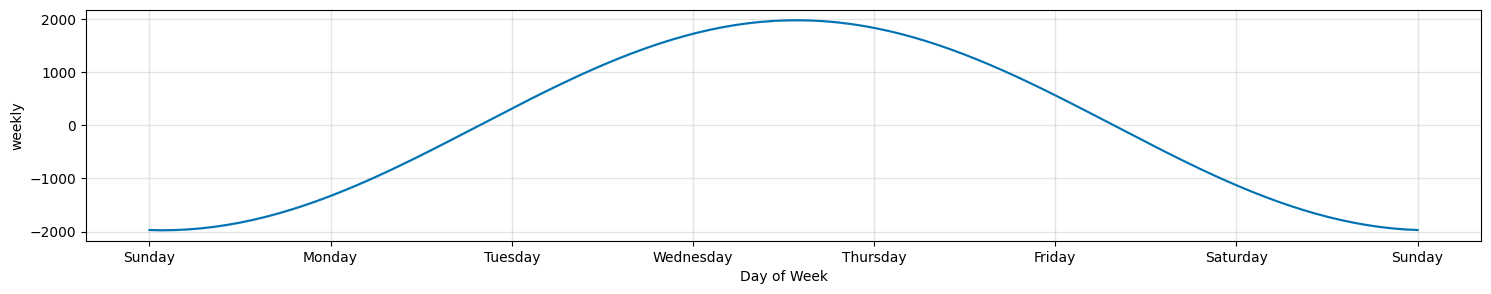

In [57]:
model = Prophet(yearly_seasonality=2, weekly_seasonality=1)   # best_yearly_seasonality=2, best_weekly_seasonality=1
model.fit(df_train)

preds = model.predict(df_test)
plot_seasonality(m=model, name="weekly", uncertainty=True, figsize=(18, 3));